## 06_2 Klassifitseerimine SVM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_excel('toofailid/DATA_TEKSTIKOGU_puhastatud.xlsx', engine='openpyxl')
print(data.shape)

(636, 55)


In [3]:
data['Lahendi liik'].value_counts()

õigeksmõistev    350
tauniv           286
Name: Lahendi liik, dtype: int64

In [4]:
print("tunnused: ", data.columns)
print("Märgendid: ", data['Lahendi liik'].value_counts())

tunnused:  Index(['#', 'title', 'text', 'Kaebuse kuupäev', 'Kaebuse aasta', 'Väljaanne',
       'Väljaande nimi1', 'Lingid', 'Lingid1', 'Dea_digar', 'Kaebuse sisu',
       'Lahendi tulemus1', 'Lahendi tulemus2', 'Lahendi kuupäev',
       'Otsuse sisu', 'Otsuse liik', 'Lahendi liik', 'Väljaande nimi',
       'Väljaande liik', 'Koodeks', '1.2', '1.4', '1.5', '1.6', '2.3', '3.1',
       '3.2', '3.3', '3.5', '3.6', '3.7', '4.1', '4.2', '4.3', '4.4', '4.6',
       '4.7', '4.8', '4.9', '4.10', '4.11', '4.12', '5.1', '5.2', '5.3', '6.1',
       'Koodeksipunkte', 'text_puhas', 'text_token', 'text_lemmatize', 'T1_4',
       'T4_1', 'T4_11', 'T_muu', 'ÕM'],
      dtype='object')
Märgendid:  õigeksmõistev    350
tauniv           286
Name: Lahendi liik, dtype: int64


In [5]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju', '-']

In [6]:
stop_tekst = []
with open("stop_s.txt", "r", encoding = 'utf8') as file:
    for line in file:
        #print(line.rstrip())
        stop_tekst.append(line.rstrip())

In [7]:
# Veamaatriks (plot the confusion matrix)
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Veamaatriks',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normaliseeritud veamaatriks")
    else:
        print('Normaliseerimata veamaatriks')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label/Tõeline märgend')
    plt.xlabel('Predicted label/Prognoositud märgend')

In [87]:
#X, y = data['text_token'], data['Lahendi liik']
X, y = data['text_lemmatize'], data['Lahendi liik'] #lemmatiseeritud tekst

In [88]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [89]:
#Encoder = LabelEncoder()
#y_train = Encoder.fit_transform(y_train)
#y_test = Encoder.fit_transform(y_test)

In [90]:
X_train

31     kohus arutama põhjalikult kas fekaalid määrima...
427    klient leidma et swedbank pidama võlgu tagasi ...
610    poliitik pidama kahetsusväärne olukord kus tap...
499    see lood ilmumine järel tulema postimees tõenä...
105    patsient minema ilukliinik suur ootus mis juht...
                             ...                        
198    kui edaspidi pidama keegi huvi tundma kust min...
93     koos kolm sõbranna mööduma neljapäev õhtu tall...
54     metsatööstur ja lageraie vajalikkus jutlustama...
356    tunduma et keskerakond olema saama iseenesestm...
489    kohtulugu • eile tartu ringkonnakohus toimuma ...
Name: text_lemmatize, Length: 508, dtype: object

In [91]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC # Support Vector Machine
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


skf =  StratifiedKFold(n_splits=10)

c_list = [0.1, 0.5, 1, 2, 5, 10, 50,100]
#c_list = [0.1, 0.5, 1, 2, 5, 5.5, 6]

mean_accuracy = []
tauniv_f1 = []
oigeks_f1 = []
w_avg_f1 = []

for c in c_list:
    print("C väärtus: " + str(c))
    
    metrics_m = []

    f1_t = []
    f1_o = []
    f1_w_avg = []
    for train_index, val_index in skf.split(X_train, y_train):
        X_treen, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_treen, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        

        pipe = Pipeline([('vect', TfidfVectorizer(
                                                  min_df = 3, 
                                                  stop_words = stop_tekst, 
                                                  max_df=0.85, 
                                                  #ngram_range=(1,2),
                                                  smooth_idf=True,
                                                  use_idf=True
                                                 )
                                                 ),
                       ('model', svm.SVC(kernel='linear', C=c))])
        #kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’

        # Mudeli sobitamine
        model = pipe.fit(X_treen, y_treen)

        # Prognoosimine
        y_pred = model.predict(X_val)
      
        metrics_m.append(accuracy_score(y_val, y_pred))
        
        tulemus = {}
        
        tulemus[c] = classification_report(y_val, y_pred, digits = 3, output_dict=True)
        print(tulemus[c]['tauniv']['f1-score'])
        f1_t.append(tulemus[c]['tauniv']['f1-score'])
        f1_o.append(tulemus[c]['õigeksmõistev']['f1-score'])
        f1_w_avg.append(tulemus[c]['weighted avg']['f1-score'])
       

        print(classification_report(y_val, y_pred, digits = 3))
        
        print('Confusion Matrix:',confusion_matrix(y_val, y_pred))
    
    #tauniv f1 skoor keskmiselt
    f1_t = np.array(f1_t)
    print('Keskmine tauniv f1: ', np.mean(f1_t, axis=0))
    tauniv_f1.append(np.mean(f1_t, axis=0))
    
    #õigeksmõistev f1 skoor keskmiselt
    f1_o = np.array(f1_o)
    print('Keskmine tauniv f1: ', np.mean(f1_o, axis=0))
    oigeks_f1.append(np.mean(f1_o, axis=0))
    
    #weighted avg f1 skoor keskmiselt
    f1_w_avg = np.array(f1_w_avg)
    print('Keskmine f1_w_avg: ', np.mean(f1_w_avg, axis=0))
    w_avg_f1.append(np.mean(f1_w_avg, axis=0))
    
    metrics_m = np.array(metrics_m)
    print('Mean accuracy: ', np.mean(metrics_m, axis=0))
    mean_accuracy.append(np.mean(metrics_m, axis=0))
    print('Std for accuracy: ', np.std(metrics_m, axis=0))

C väärtus: 0.1


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.0
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        23
õigeksmõistev      0.549     1.000     0.709        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.275     0.500     0.354        51
 weighted avg      0.301     0.549     0.389        51

Confusion Matrix: [[ 0 23]
 [ 0 28]]
0.0
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        23
õigeksmõistev      0.549     1.000     0.709        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.275     0.500     0.354        51
 weighted avg      0.301     0.549     0.389        51

Confusion Matrix: [[ 0 23]
 [ 0 28]]
0.0
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        23
õigeksmõistev      0.549     1.000     0.709        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.275  

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.22222222222222218
               precision    recall  f1-score   support

       tauniv      0.750     0.130     0.222        23
õigeksmõistev      0.574     0.964     0.720        28

    micro avg      0.588     0.588     0.588        51
    macro avg      0.662     0.547     0.471        51
 weighted avg      0.654     0.588     0.496        51

Confusion Matrix: [[ 3 20]
 [ 1 27]]
0.21428571428571427
               precision    recall  f1-score   support

       tauniv      0.600     0.130     0.214        23
õigeksmõistev      0.565     0.929     0.703        28

    micro avg      0.569     0.569     0.569        51
    macro avg      0.583     0.530     0.458        51
 weighted avg      0.581     0.569     0.482        51

Confusion Matrix: [[ 3 20]
 [ 2 26]]
0.20689655172413793
               precision    recall  f1-score   support

       tauniv      0.500     0.130     0.207        23
õigeksmõistev      0.556     0.893     0.685        28

    micro avg      0.549     0.54

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.6153846153846153
               precision    recall  f1-score   support

       tauniv      0.750     0.522     0.615        23
õigeksmõistev      0.686     0.857     0.762        28

    micro avg      0.706     0.706     0.706        51
    macro avg      0.718     0.689     0.689        51
 weighted avg      0.715     0.706     0.696        51

Confusion Matrix: [[12 11]
 [ 4 24]]
0.4571428571428571
               precision    recall  f1-score   support

       tauniv      0.667     0.348     0.457        23
õigeksmõistev      0.615     0.857     0.716        28

    micro avg      0.627     0.627     0.627        51
    macro avg      0.641     0.602     0.587        51
 weighted avg      0.639     0.627     0.599        51

Confusion Matrix: [[ 8 15]
 [ 4 24]]
0.3888888888888889
               precision    recall  f1-score   support

       tauniv      0.538     0.304     0.389        23
õigeksmõistev      0.579     0.786     0.667        28

    micro avg      0.569     0.569  

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.6
               precision    recall  f1-score   support

       tauniv      0.706     0.522     0.600        23
õigeksmõistev      0.676     0.821     0.742        28

    micro avg      0.686     0.686     0.686        51
    macro avg      0.691     0.672     0.671        51
 weighted avg      0.690     0.686     0.678        51

Confusion Matrix: [[12 11]
 [ 5 23]]
0.39999999999999997
               precision    recall  f1-score   support

       tauniv      0.471     0.348     0.400        23
õigeksmõistev      0.559     0.679     0.613        28

    micro avg      0.529     0.529     0.529        51
    macro avg      0.515     0.513     0.506        51
 weighted avg      0.519     0.529     0.517        51

Confusion Matrix: [[ 8 15]
 [ 9 19]]
0.4186046511627907
               precision    recall  f1-score   support

       tauniv      0.450     0.391     0.419        23
õigeksmõistev      0.548     0.607     0.576        28

    micro avg      0.510     0.510     0.510      

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.6
               precision    recall  f1-score   support

       tauniv      0.706     0.522     0.600        23
õigeksmõistev      0.676     0.821     0.742        28

    micro avg      0.686     0.686     0.686        51
    macro avg      0.691     0.672     0.671        51
 weighted avg      0.690     0.686     0.678        51

Confusion Matrix: [[12 11]
 [ 5 23]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.4444444444444445
               precision    recall  f1-score   support

       tauniv      0.455     0.435     0.444        23
õigeksmõistev      0.552     0.571     0.561        28

    micro avg      0.510     0.510     0.510      

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.6
               precision    recall  f1-score   support

       tauniv      0.706     0.522     0.600        23
õigeksmõistev      0.676     0.821     0.742        28

    micro avg      0.686     0.686     0.686        51
    macro avg      0.691     0.672     0.671        51
 weighted avg      0.690     0.686     0.678        51

Confusion Matrix: [[12 11]
 [ 5 23]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.4444444444444445
               precision    recall  f1-score   support

       tauniv      0.455     0.435     0.444        23
õigeksmõistev      0.552     0.571     0.561        28

    micro avg      0.510     0.510     0.510      

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.6
               precision    recall  f1-score   support

       tauniv      0.706     0.522     0.600        23
õigeksmõistev      0.676     0.821     0.742        28

    micro avg      0.686     0.686     0.686        51
    macro avg      0.691     0.672     0.671        51
 weighted avg      0.690     0.686     0.678        51

Confusion Matrix: [[12 11]
 [ 5 23]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.4680851063829787
               precision    recall  f1-score   support

       tauniv      0.458     0.478     0.468        23
õigeksmõistev      0.556     0.536     0.545        28

    micro avg      0.510     0.510     0.510      

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.6
               precision    recall  f1-score   support

       tauniv      0.706     0.522     0.600        23
õigeksmõistev      0.676     0.821     0.742        28

    micro avg      0.686     0.686     0.686        51
    macro avg      0.691     0.672     0.671        51
 weighted avg      0.690     0.686     0.678        51

Confusion Matrix: [[12 11]
 [ 5 23]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.4680851063829787
               precision    recall  f1-score   support

       tauniv      0.458     0.478     0.468        23
õigeksmõistev      0.556     0.536     0.545        28

    micro avg      0.510     0.510     0.510      

In [92]:
d = {'c-väärtus': c_list, 'tauniv f1': tauniv_f1, 'õigeksmõistev f1': oigeks_f1,'weighted avg f1': w_avg_f1}
df = pd.DataFrame(data=d)

In [93]:
df

,c-väärtus,tauniv f1,õigeksmõistev f1,weighted avg f1
0,0.1,0.000000,0.710678,0.391753
1,0.5,0.283229,0.711051,0.518967
2,1.0,0.518667,0.692579,0.614374
3,2.0,0.513053,0.632847,0.578937
4,5.0,0.502972,0.618887,0.566727
5,10.0,0.501152,0.620330,0.566698
6,50.0,0.494472,0.613329,0.559842
7,100.0,0.500907,0.612850,0.562459


In [80]:
for i in range(len(c_list)):
    print(str(c_list[i]) + '\t ' + str(mean_accuracy[i]))

0.1	 0.5512156862745099
0.5	 0.602549019607843
1	 0.6398431372549019
2	 0.6083137254901961
5	 0.6023921568627453
10	 0.6043921568627452
50	 0.6102745098039216
100	 0.6102745098039216


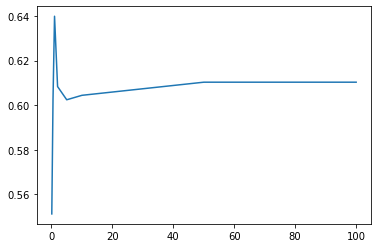

In [81]:
plt.plot(c_list, mean_accuracy)

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

Normaliseerimata veamaatriks
SVM mudeli ennustustäpsus: 61.72%
               precision    recall  f1-score   support

       tauniv      0.629     0.379     0.473        58
õigeksmõistev      0.613     0.814     0.699        70

    micro avg      0.617     0.617     0.617       128
    macro avg      0.621     0.597     0.586       128
 weighted avg      0.620     0.617     0.597       128



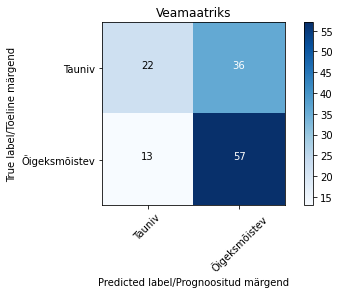

In [94]:
pipe_valitud = Pipeline([('vect', TfidfVectorizer(
                                          min_df = 3, 
                                          stop_words = stop_tekst, 
                                          max_df=0.85, 
                                          #ngram_range=(1,2),
                                          smooth_idf=True,
                                          use_idf=True
                                         )
                                         ),
                       ('model_valitud', svm.SVC(kernel='linear', C=1))])

# Mudeli sobitamine
model_valitud = pipe_valitud.fit(X_train, y_train)

# Prognoosimine
y_pred_valitud = model_valitud.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred_valitud)
plot_confusion_matrix(cm, classes=['Tauniv', 'Õigeksmõistev'])
print("SVM mudeli ennustustäpsus: {}%".format(round(accuracy_score(y_test, y_pred_valitud)*100,2)))
print(classification_report(y_test, y_pred_valitud, digits = 3))